## **Mount implementation folder in google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/FYP/Implementation/data
! ls

/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/data
encoded-data.csv	preprosessing-dos.csv  UNSW-NB15_1.csv
NUSW-NB15_features.csv	selected_columns.csv   UNSW-NB15_2.csv
OTset.csv		SVR-predict-data.csv   UNSW-NB15_3.csv
preprocessing.csv	testset.csv	       UNSW-NB15_4.csv


## **Get random rows from excell files**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df0 = pd.read_csv('NUSW-NB15_features.csv', encoding='cp1252')

df1 = pd.read_csv('UNSW-NB15_1.csv',names=df0.iloc[:]['Name'], header=None)
df2 = pd.read_csv('UNSW-NB15_2.csv',names=df0.iloc[:]['Name'], header=None)
df3 = pd.read_csv('UNSW-NB15_3.csv',names=df0.iloc[:]['Name'], header=None)
df4 = pd.read_csv('UNSW-NB15_4.csv',names=df0.iloc[:]['Name'], header=None)

frames = [df1, df2, df3, df4]
result = pd.concat(frames)
result['attack_cat'] = result['attack_cat'].str.strip()
result['attack_cat'] = result['attack_cat'].replace('Backdoor','Backdoors')
X=result.drop(labels=['attack_cat','Label'], axis=1)
Y=result[['attack_cat','Label']]
# split the dataset
# X_train, X_test_total, Y_train, Y_test_total = train_test_split(X, Y, test_size=0.4, random_state=0)
X_train, X_test_total, Y_train, Y_test_total = train_test_split(X, Y, test_size=0.4, random_state=0)
X_OT, X_test, Y_OT, Y_test = train_test_split(X_test_total, Y_test_total, test_size=0.5, random_state=0)

#60% for training
train_set = pd.concat([X_train, Y_train],axis=1)
train_set.to_csv("preprocessing.csv", header=True, index=False)

#20% for testing
test_set = pd.concat([X_test, Y_test],axis=1)
test_set.to_csv("testset.csv", header=True, index=False)

#20% for Online learning
OT_set = pd.concat([X_OT, Y_OT],axis=1)
OT_set.to_csv("OTset.csv", header=True, index=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## **Creating Seperate Label columns for Different Attacks**

In [ ]:
import pandas as pd
import numpy as np

result=pd.read_csv('preprocessing.csv', sep=',', on_bad_lines='skip', index_col=False)

attack_categories = list(result['attack_cat'].unique())
attack_categories.remove(float(np.NaN))

for index, val in enumerate(attack_categories):
  attack_categories[index] = str(val).strip()

print(attack_categories)
attack_categories = list(set(attack_categories))
attack_categories.sort()
print(attack_categories)

for i in attack_categories:
  result[i] = result['attack_cat'].apply(lambda x: 1 if x == i else 0)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


['Exploits', 'Generic', 'Reconnaissance', 'Analysis', 'Fuzzers', 'DoS', 'Backdoors', 'Shellcode', 'Worms']
['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms']


## **Feature Selection**

**Drop columns with a high missing value Percentage**

In [ ]:
import pandas as pd
import numpy as np

attack_labels = attack_categories + ['attack_cat','Label']
X=result.drop(labels=attack_labels, axis=1)
# Y=df[['attack_cat','Label']]
Y=result[['DoS']]
#replace missing values with NaN
X = X.replace('-','')
X = X.replace(r'^\s*$', np.nan, regex=True)

# printing missing value percentages of each column
percent_missing = X.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': X.columns, 'count_missing': percent_missing, 'To be dropped': (percent_missing > 45)})
print(missing_value_df)

# removing columns with high missing value %s
X = X.drop(['service','ct_flw_http_mthd','is_ftp_login','ct_ftp_cmd'],axis=1)

# finding rows with NaN value for dsport,sport and drop them
for i in X.columns.values.tolist():
  i = X.loc[X[i].isnull()].index
  X = X.drop(index=list(i))
  Y = Y.drop(index=list(i))
  result = result.drop(index=list(i))

(X.shape, Y.shape)
percent_missing = X.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': X.columns, 'count_missing': percent_missing, 'To be dropped': (percent_missing > 45)})
print(missing_value_df)

                       column_name  count_missing  To be dropped
srcip                        srcip              0          False
sport                        sport              0          False
dstip                        dstip              0          False
dsport                      dsport              4          False
proto                        proto              0          False
state                        state              0          False
dur                            dur              0          False
sbytes                      sbytes              0          False
dbytes                      dbytes              0          False
sttl                          sttl              0          False
dttl                          dttl              0          False
sloss                        sloss              0          False
dloss                        dloss              0          False
service                    service         748488           True
Sload                    

**Label Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# replace hex with int
X['sport'] = X['sport'].astype(str).apply(int, base=16)
X['dsport'] = X['dsport'].astype(str).apply(int, base=16)

# #Create an instance of Label-encoder
labelencoder = LabelEncoder() 

# # encode columns consists with strings
X['srcip'] = labelencoder.fit_transform(X['srcip'])
X['dstip'] = labelencoder.fit_transform(X['dstip'])
X['proto'] = labelencoder.fit_transform(X['proto'])
X['state'] = labelencoder.fit_transform(X['state'])

X.head(n=100)

percent_missing = X.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': X.columns, 'count_missing': percent_missing, 'To be dropped': (percent_missing > 45)})
print(missing_value_df)

                       column_name  count_missing  To be dropped
srcip                        srcip              0          False
sport                        sport              0          False
dstip                        dstip              0          False
dsport                      dsport              0          False
proto                        proto              0          False
state                        state              0          False
dur                            dur              0          False
sbytes                      sbytes              0          False
dbytes                      dbytes              0          False
sttl                          sttl              0          False
dttl                          dttl              0          False
sloss                        sloss              0          False
dloss                        dloss              0          False
Sload                        Sload              0          False
Dload                    

**Pearson Correlation**

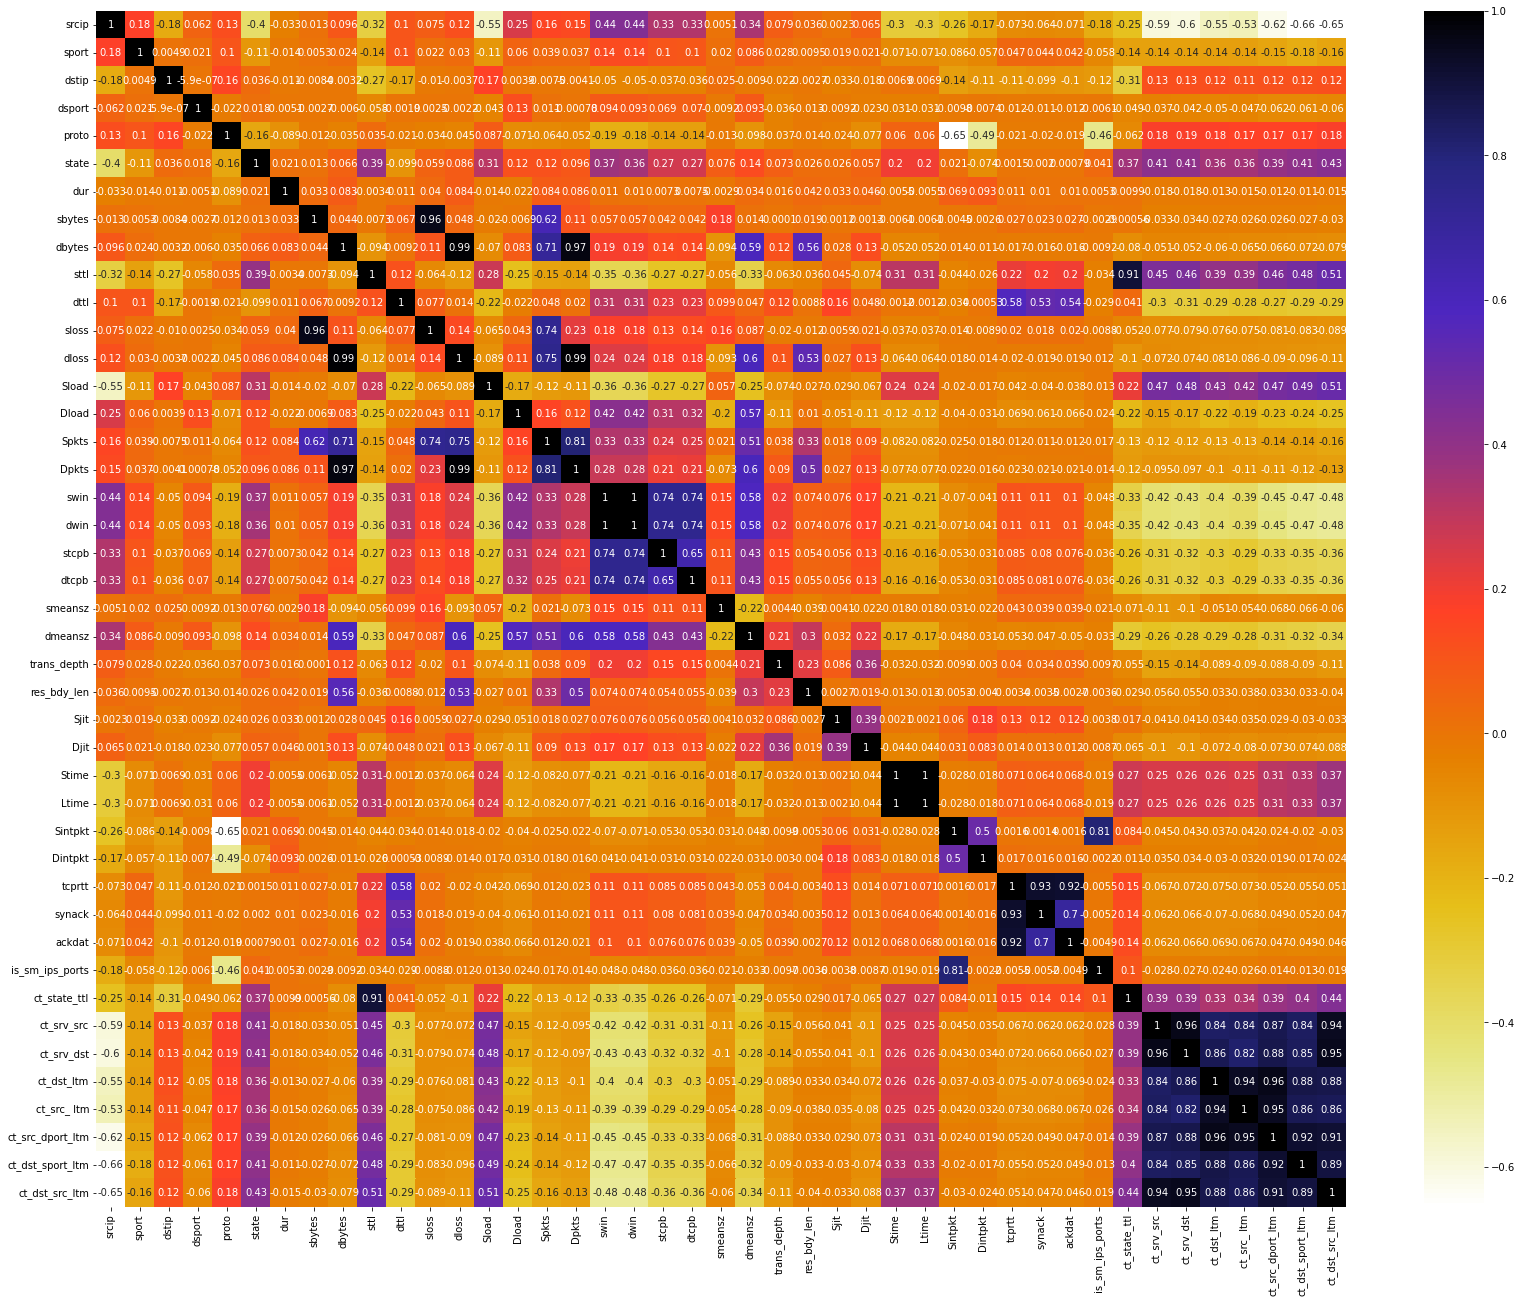

No of col dropped: 8
                       column_name  count_missing  To be dropped
srcip                        srcip              0          False
sport                        sport              0          False
dstip                        dstip              0          False
dsport                      dsport              0          False
proto                        proto              0          False
state                        state              0          False
dur                            dur              0          False
sbytes                      sbytes              0          False
dbytes                      dbytes              0          False
sttl                          sttl              0          False
dttl                          dttl              0          False
Sload                        Sload              0          False
Dload                        Dload              0          False
Spkts                        Spkts              0          False
swin

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Using Pearson Correlation
plt.figure(figsize=(28,22))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()


def correlation(dataset, threshold):
    col_corr = dict()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.index)):
            if i==j:
              continue
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname=corr_matrix.columns[i]  # getting the name of column
                rowname = corr_matrix.index[j]  # getting the name of row
                if col_corr.get(rowname,0)==0:
                  col_corr[rowname] = [colname]
                else: col_corr[rowname].append(colname)

    return col_corr

def correlation_col(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr


list_corr=correlation_col(X,0.95)
print("No of col dropped:",len(list_corr))
# drop columns with corr> 0.9
X = X.drop(list_corr,axis=1)
(X.shape, Y.shape)

percent_missing = X.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': X.columns, 'count_missing': percent_missing, 'To be dropped': (percent_missing > 45)})
print(missing_value_df)



**Save filtered common Data to encoded-data.csv**

In [ ]:
#write processed encoded data into encoded-data.csv
import pandas as pd

encoded_data = pd.concat([X,result[attack_labels]],axis=1)
encoded_data.head()
print(X.shape,result[attack_labels].shape)
# percent_missing = result[attack_labels].isnull().sum()
# missing_value_df = pd.DataFrame({'column_name': result[attack_labels].columns, 'count_missing': percent_missing, 'To be dropped': (percent_missing > 45)})
# print(missing_value_df)
encoded_data.to_csv("encoded-data.csv", header=True, index=False)

(1524024, 35) (1524024, 11)
